# `multidms` fitting pipeline

Here, we demonstrate the pipeline for fitting a `multidms` model to data from [two deep mutational scanning experiments](https://github.com/dms-vep) across Delta and Omicron BA.2 Spike protein.

In [3]:
import os
import sys
from collections import defaultdict
import time
import pickle

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as onp
from tqdm.notebook import tqdm
import jax.numpy as jnp

import multidms
%matplotlib inline

Read in the dms data and list all available experimental conditions.

In [4]:
func_score_df = pd.read_csv("Delta_BA1_BA2_func_score_df.csv").fillna({"aa_substitutions":""})
avail_conditions = ' '.join(list(func_score_df.condition.unique()))
print(f"The following conditions are available for fitting: \n{avail_conditions}")
func_score_df.sample(frac=1).head().sort_values("condition")

The following conditions are available for fitting: 
Delta-1 Delta-2 Delta-3 Delta-4 Omicron_BA.1-1 Omicron_BA.1-2 Omicron_BA.1-3 Omicron_BA.2-1 Omicron_BA.2-2


,func_score,aa_substitutions,condition
260592,-3.5000,E298G R765M D1118G N1135I,Omicron_BA.1-2
429833,0.3775,F1156L,Omicron_BA.2-1
557895,-1.5138,D950G V1228H,Omicron_BA.2-2
610830,0.6293,L226F N953T,Omicron_BA.2-2
545768,-0.4347,F59L,Omicron_BA.2-2


Choose a reference and all other conditions to be included in the fit. Query the func_score_df sample conditions to be included in a fit.

In [8]:
reference_condition = "Delta-3"
fit_included_conditions = ['Delta-3', 'Omicron_BA.2-1']
func_score_df = func_score_df.query(
    f"condition.isin({fit_included_conditions})"
)

## `MultiDmsData`

After the functional score dataframe for all variants has been prepped, you can now initialize a `mulidms.MultiDmsData` Object. This will (1) convert substitution string to be with respect to a reference (if necessary) (2) set static attributes and (3) prep model training data which can be shared by multiple `multidms.MulitDmsModel` objects.

**Note** The current implimentation for string mutation representations is quite slow, we're working on improving this.

In [9]:
# uncomment to see docs
# help(multidms.MultiDmsData)

In [10]:
data = multidms.MultiDmsData(
    func_score_df,
    alphabet= multidms.AAS_WITHSTOP,
    condition_colors = sns.color_palette("Paired"),
    reference=reference_condition
)

  0%|          | 0/5363 [00:00<?, ?it/s]

We can now view a few useful attributes

In [11]:
data.site_map.head()

,Delta-3,Omicron_BA.2-1
1020,A,A
1163,D,D
1026,A,A
1191,K,K
1056,A,A


In [12]:
data.mutations[:5]

('F2L', 'V3A', 'V3F', 'V3G', 'V3I')

In [13]:
data.mutations_df.head()

,mutation,wts,sites,muts,times_seen_Delta-3,times_seen_Omicron_BA.2-1
0,F2L,F,2,L,1.0,1.0
1,V3A,V,3,A,0.0,1.0
2,V3F,V,3,F,0.0,7.0
3,V3G,V,3,G,0.0,1.0
4,V3I,V,3,I,2.0,5.0


In [14]:
data.conditions

('Omicron_BA.2-1', 'Delta-3')

In [15]:
data.reference

'Delta-3'

In [16]:
data.binarymaps

{'Delta-3': <binarymap.binarymap.BinaryMap at 0x7f935e7434c0>,
 'Omicron_BA.2-1': <binarymap.binarymap.BinaryMap at 0x7f935d79bcd0>}

In [17]:
data.non_identical_sites

frozendict.frozendict({'Omicron_BA.2-1': array([417, 681, 375, 950, 501, 484, 493,  27, 679, 498, 505, 452, 440,
       408, 954, 213, 796, 655, 477, 405, 156, 339, 969, 373, 764, 371,
       376,  19]), 'Delta-3': []})

In [18]:
data.non_identical_mutations

frozendict.frozendict({'Omicron_BA.2-1': 'K417N R681H S375F N950D N501Y E484A Q493R A27S N679K Q498R Y505H R452L N440K R408S Q954H V213G D796Y H655Y S477N D405N G156E G339D N969K S373P N764K S371F T376A R19I', 'Delta-3': ''})

## `MultiDmsModel`

Next, we iterate through datasets and model definitions of interest and (1) initialize a model object with the respective dataset (2) fit that data to a model with some given hyperparameters and (3) save the models in a dataframe for comparison and plotting.

**Note** Models with the same dataset share the reference. This saves precious memory.

In [21]:
model = multidms.MultiDmsModel(
        data,
        epistatic_model=multidms.model.sigmoidal_global_epistasis,
)

start = time.time()
model.fit(lasso_shift=1e-5, maxiter=2000, tol=1e-6)
end = time.time()
print(f"done. fitting time = {round(end - start, 2)} seconds")

done. fitting time = 9.77 seconds


The Model object shares many similar properties from the data object, like mutations and variants dataframes, but the getters give you useful model-specific features like parameters and predictions.

In [23]:
model.mutations_df

,mutation,wts,sites,muts,times_seen_Delta-3,times_seen_Omicron_BA.2-1,β,S_Omicron_BA.2-1,F_Omicron_BA.2-1,S_Delta-3,F_Delta-3
0,F2L,F,2,L,1.0,1.0,-1.216929,0.042178,-1.400998,0.0,-1.041498
1,V3A,V,3,A,0.0,1.0,-0.389948,0.083642,-0.635657,0.0,-0.389045
2,V3F,V,3,F,0.0,7.0,-0.121274,-0.320562,-0.743367,0.0,-0.226988
3,V3G,V,3,G,0.0,1.0,0.274638,1.484698,0.265222,0.0,-0.034354
4,V3I,V,3,I,2.0,5.0,-0.123078,0.297520,-0.304309,0.0,-0.227989
...,...,...,...,...,...,...,...,...,...,...,...
5778,S1252T,S,1252,T,3.0,4.0,-1.859092,2.987464,0.118060,0.0,-1.641035
5779,S1252V,S,1252,V,2.0,3.0,0.836396,2.848598,0.420720,0.0,0.157207
5780,S1252W,S,1252,W,0.0,1.0,1.867402,0.070382,0.293967,0.0,0.339255
5781,S1252Y,S,1252,Y,0.0,11.0,0.696520,-1.046602,-0.669809,0.0,0.117296


In [24]:
model.variants_df

,condition,aa_substitutions,weight,func_score,var_wrt_ref,predicted_latent,predicted_func_score,corrected_func_score
0,Delta-3,,200,-0.240396,,1.645312,-0.162308,-0.240396
1,Delta-3,A1020E,1,-0.749500,A1020E,0.867467,-0.668583,-0.749500
2,Delta-3,A1020E D1163T,1,-0.010800,A1020E D1163T,1.782269,-0.095377,-0.010800
3,Delta-3,A1020M,2,-1.328400,A1020M,0.302720,-1.156246,-1.328400
4,Delta-3,A1020N,1,1.882300,A1020N,3.783326,0.364605,1.882300
...,...,...,...,...,...,...,...,...
8416,Omicron_BA.2-1,Y837N,1,-2.005400,K417N R681H S375F N950D N501Y E484A Q493R A27S...,1.480344,-0.251568,-1.789096
8419,Omicron_BA.2-1,Y91D T1027P,1,-3.500000,K417N R681H S375F N950D N501Y E484A T1027P Q49...,-2.486011,-3.038229,-3.283696
8420,Omicron_BA.2-1,Y91F L176I,1,-0.040400,K417N R681H S375F N950D N501Y E484A Q493R A27S...,2.783133,0.228625,0.175904
8421,Omicron_BA.2-1,Y91F S94L L176T H1058Y A1226S,1,-3.500000,K417N R681H S375F N950D N501Y E484A Q493R A27S...,-3.248908,-3.187343,-3.283696


### Visualization

<function matplotlib.pyplot.show(close=None, block=None)>

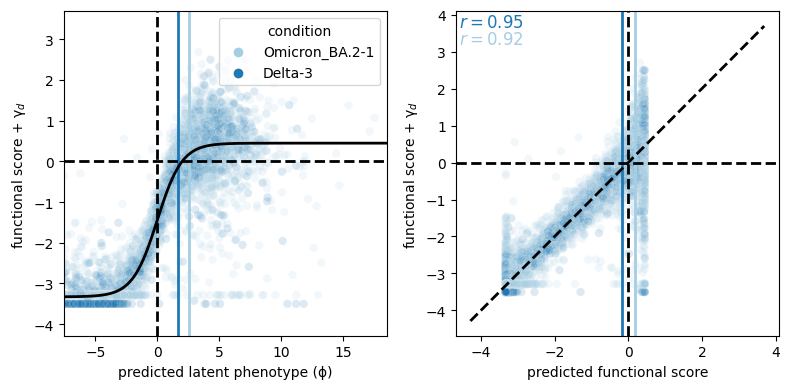

In [27]:
fig, ax = plt.subplots(1, 2, figsize=[8,4])
model.plot_epistasis(ax=ax[0], alpha=0.15, show=False)
model.plot_pred_accuracy(ax=ax[1], alpha=0.15, show=False, legend=False)
plt.show

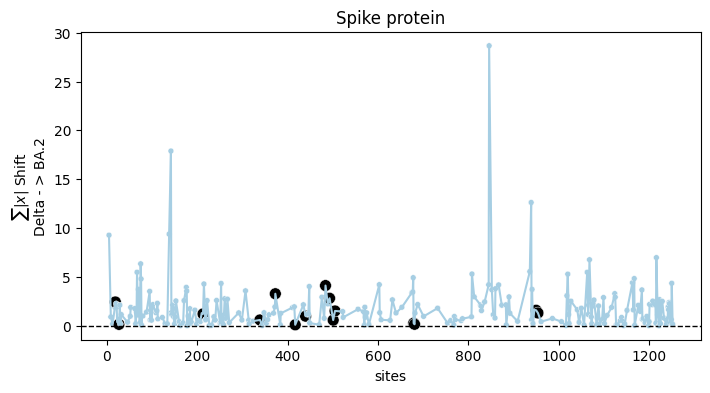

In [30]:
fig, ax = plt.subplots(figsize=[8,4])
agg_func = lambda x: onp.abs(onp.mean(onp.sum(x)))
model.plot_shifts_by_site(ax=ax, condition="Omicron_BA.2-1", agg_func=agg_func, show=False)
ax.set_ylabel("$\sum |x|$ Shift\nDelta - > BA.2")
ax.set_title("Spike protein")
plt.show()

We offer the ability to interactively visualize a model's shift parameters using the `MultiDmsModel.mut_shift_plot()` method which wraps the original viz function from `polyclonal.plot.lineplot_and_heatmap()` as seen [here](https://github.com/jbloomlab/polyclonal/blob/92fee4badb14e1db719074f202b4fab374dd0613/polyclonal/plot.py#L263) 

**NOTE:** Currently, the heatmaps place an "X" at the wildtype for the reference sequence _only_. Note that you quite easily look up the wildtypes for any homolog at a given site using the `MultiDmdData.site_map` property.

In [31]:
data.non_identical_sites

frozendict.frozendict({'Omicron_BA.2-1': array([417, 681, 375, 950, 501, 484, 493,  27, 679, 498, 505, 452, 440,
       408, 954, 213, 796, 655, 477, 405, 156, 339, 969, 373, 764, 371,
       376,  19]), 'Delta-3': []})

In [33]:
chart = model.mut_shift_plot()
chart

/home/jgallowa/miniconda3/envs/multidms_toml/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)